In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Circle, Rectangle
from matplotlib.collections import LineCollection

In [2]:
def line_intersect(p1, p2, P3, P4):
    # calcule les coordonnées des points d'intersections entre deux segments. Ici entre le rayon du senseur et du mur

    # on récupère les coodonnées de tous les segments que formé par les senseurs
    p1 = np.atleast_2d(p1) 
    p2 = np.atleast_2d(p2)
    # on récupère les coordonnées des segments des murs du labyrinthe
    P3 = np.atleast_2d(P3)
    P4 = np.atleast_2d(P4)
    

    x1, y1 = p1[:,0], p1[:,1]
    x2, y2 = p2[:,0], p2[:,1]
    X3, Y3 = P3[:,0], P3[:,1]
    X4, Y4 = P4[:,0], P4[:,1]

    #colinéarité entre le vecteur senseur et le mur 
    D = (Y4-Y3)*(x2-x1) - (X4-X3)*(y2-y1)

    # Colinearity test
    C = (D != 0)
    UA = ((X4-X3)*(y1-Y3) - (Y4-Y3)*(x1-X3))
    UA = np.divide(UA, D, where=C)
    UB = ((x2-x1)*(y1-Y3) - (y2-y1)*(x1-X3))
    UB = np.divide(UB, D, where=C)

    # Test if intersections are inside each segment
    C = C * (UA > 0) * (UA < 1) * (UB > 0) * (UB < 1)
    
    X = np.where(C, x1 + UA*(x2-x1), np.inf)
    Y = np.where(C, y1 + UA*(y2-y1), np.inf)
    return np.stack([X,Y],axis=1)

In [3]:
class Maze:
    """
    A simple 8-maze made of straight walls (line segments)
    """

    def __init__(self):
        self.walls = np.array( [

            # Surrounding walls
            [ (  0,   0), (  0, 500)],
            [ (  0, 500), (300, 500)],
            [ (300, 500), (300,   0)],
            [ (300,   0), (  0,   0)],
            
            # Bottom hole
            [ (100, 100), (200, 100)],
            [ (200, 100), (200, 200)],
            [ (200, 200), (100, 200)],
            [ (100, 200), (100, 100)],

            # Top hole
            [ (100, 300), (200, 300)],
            [ (200, 300), (200, 400)],
            [ (200, 400), (100, 400)],
            [ (100, 400), (100, 300)],

            # Moving walls (invisibles) to constraing bot path
            [ (  0, 250), (100, 200)],
            [ (200, 300), (300, 250)] 
        ] )

In [35]:
class Bot:
    
    def __init__(self):
        self.size = 10
        self.position = 150,250
        self.orientation = 0
        self.n_sensors = 8
        A = np.linspace(-np.pi/2, +np.pi/2, self.n_sensors+2, endpoint=True)[1:-1]
        self.sensors = {
            "angle" : A,
            "range" : 75*np.ones((self.n_sensors,1)),
            "value" : np.ones((self.n_sensors,1)) }

    def draw(self, ax):

        # Sensors
        n = 2*len(self.sensors["angle"])
        sensors = LineCollection(np.zeros((n,2,2)),
                                 colors = ["0.75", "0.00"] * n,
                                 linewidths = [0.75, 1.00] * n,
                                 linestyles = ["--", "-"] * n)
        # Body 
        body = Circle(self.position, self.size, zorder=20,
                      edgecolor="black", facecolor=(1,1,1,.75))

        # Head
        P = np.zeros((1,2,2))
        P[0,0] = self.position
        P[0,1] = P[0,1] + self.size * np.array([np.cos(self.orientation),
                                                np.sin(self.orientation)])

    
    def update(self, maze):
        # Sensors
        A = self.sensors["angle"] + self.orientation # angles de tous les senseurs
        T = np.stack([np.cos(A), np.sin(A)], axis=1) # gradient ? de tous les angles des senseurs
        P1 = self.position + self.size*T # positions dans le plan de tous les senseurs du robot
        P2 = P1 + self.sensors["range"]*T # coordonées de la fin du segment formé a partir du senseur et jusq'uà sa distance de vision
        P3, P4 = maze.walls[:,0], maze.walls[:,1] # coordonnées de tous les murs du labyrinthe 
        for i, (p1, p2) in enumerate(zip(P1,P2)): # pour tous les segments robot-range 
            C = line_intersect(p1, p2, P3, P4) # calcul du point d'intersection entre la vision et le mur du labyrinthe
            index = np.argmin( ((C - p1)**2).sum(axis=1)) # somme des distances au carré du robot aux intersections, on obtient le nom du senseur de plus petit distance au mur 
            p = C[index] # on récupère la plus petite distance au mur
            if p[0] < np.inf: # si la distance est finie alors:
                self.sensors["value"][i] = np.sqrt(((p1-p)**2).sum())
                self.sensors["value"][i] /= self.sensors["range"][i]
            else:
                self.sensors["value"][i] = 1

In [36]:
def update():
    dv = (bot.sensors["value"].ravel() * [-4,-3,-2,-1,1,2,3,4]).sum()
    if abs(dv) > 0.5:
        bot.orientation += 0.01 * dv
    bot.position += 2 * np.array([np.cos(bot.orientation),
                                  np.sin(bot.orientation)])
    bot.update(maze)

    # Moving walls
    if bot.position[1] < 100:
        maze.walls[12:] = [[(0, 250), (100, 300)], [(200, 200), (300, 250)]]
    elif bot.position[1] > 400:
        maze.walls[12:] = [[(0, 250), (100, 200)], [(200, 300), (300, 250)]]
    return 
    

In [37]:
#on construit le data set pour entrainer le modèle, 10_000 données recoupant les valeurs des senseurs, le theta, la position

# initialisation des variables
maze = Maze()
bot = Bot()
bot.position = 150, 250
bot.orientation = 0
bot.sensors["range"][3:5] *= 1.25
set_size= 10_000
#  création du tableau 
Data_set=np.zeros((set_size,11))


for i in range(set_size):
    sensors_data=bot.sensors["value"].ravel()
    angle= [bot.orientation]
    position= bot.position
    Data_set[i]=np.concatenate((sensors_data,angle,bot.position))
    update()

In [38]:
Data_set[:, 9:11]

array([[150.        , 250.        ],
       [152.        , 250.        ],
       [154.        , 250.        ],
       ...,
       [ 35.41851606, 373.76727028],
       [ 36.06911488, 371.87604814],
       [ 36.73931971, 369.99168473]])

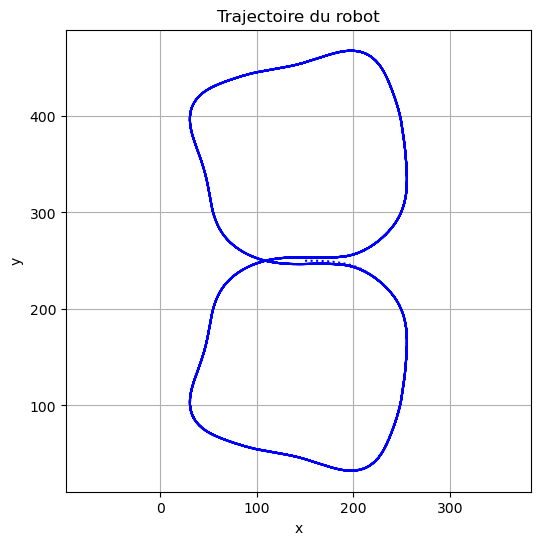

In [30]:
# Extraire les colonnes 9 et 10
positions = Data_set[:, 9:11]  # shape (N, 2)

# Tracer la trajectoire
plt.figure(figsize=(6,6))
plt.plot(positions[:, 0], positions[:, 1], linestyle=":", color="blue")
plt.title("Trajectoire du robot")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")  # pour garder les proportions
plt.grid(True)
plt.show()

In [34]:
#Verifier les occurences et nombre de tours effectués par l'agent
import numpy as np
from collections import Counter

# Extraire les positions (colonnes 9 et 10)
positions = Data_set[:, 9:11]

# Option : arrondir les positions à l'entier (ou 0.5 si tu veux plus fin)
rounded_positions = np.round(positions,decimals=1)  # shape (N, 2)

# Convertir en tuples pour compter facilement
tuple_positions = [tuple(pos) for pos in rounded_positions]

# Compter les occurrences
counts = Counter(tuple_positions)

# Trouver la position la plus fréquente
most_common_pos, freq = counts.most_common(1)[0]

print(f"Position la plus fréquente : {most_common_pos} (vue {freq} fois)")

Position la plus fréquente : (91.5, 243.8) (vue 14 fois)
